In [ ]:
import os
import glob
import librosa
from mfcc import *
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
DATA_PATH = "./genres/"
genres = {}

genres = {name: i for i, name in enumerate(os.listdir(DATA_PATH)) if os.path.isdir(DATA_PATH + name)}
print(genres)
if os.path.exists("./dataset.csv"):
    df = pd.read_csv("./dataset.csv", header = 0)
else:
    X, y = parseAudio(DATA_PATH, genres, mfcc_coeff = 20)
    features = ["mfcc_" + str(i + 1) for i in range(len(X[0]) - 2)]
    features.append("amplitude_envelope")
    features.append("RMSE")
    df = pd.DataFrame(X, columns = features)
    df["target"] = y
    df.to_csv(r"./dataset.csv", index = False)

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]
sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
# Splitting data for train and test
X_train = pd.DataFrame(X_train)
X_train["category"] = y_train

In [ ]:
sns.pairplot(X_train, hue = "category")
X_train = X_train.drop(columns = ['category'])

In [111]:
# Training KMC Model
kmc_model = KMeans(n_clusters = len(genres))
kmc_model.fit(X_train)

# Training KNN Model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Training SVM Model
svm_linear = svm.SVC(kernel='linear', gamma = 0.5, C = 1).fit(X_train, y_train)
svm_poly = svm.SVC(kernel='poly', degree = 1, C = 1).fit(X_train, y_train)

KMC Predict accuracy: 3.0 %
KNN Predict accuracy: 58.666666666666664 %
SVM Polynomial Predict accuracy: 58.333333333333336 %
SVM Linear Predict accuracy: 60.66666666666667 %


,KNN,KMC,Linear SVM,Polynomial SVM,Actual
0,classical,hiphop,classical,classical,classical
1,hiphop,disco,hiphop,hiphop,hiphop
2,country,pop,blues,blues,jazz
3,reggae,metal,reggae,reggae,reggae
4,reggae,disco,jazz,jazz,blues
...,...,...,...,...,...
295,hiphop,jazz,hiphop,hiphop,hiphop
296,classical,rock,jazz,jazz,reggae
297,reggae,disco,reggae,reggae,reggae
298,jazz,blues,jazz,country,jazz


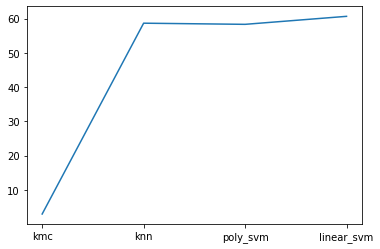

In [112]:
genres_inv = {v: k for k, v in genres.items()}
y_test_val = np.array([genres_inv[i] for i in y_test])
accuracy = dict()

# KMC Prediction
kmc_pred = kmc_model.predict(X_test)
kmc_pred_val = np.array([genres_inv[i] for i in kmc_pred])
kmc_accuracy = accuracy_score(kmc_pred, y_test)
accuracy["kmc"]  = kmc_accuracy * 100
print("KMC Predict accuracy:", kmc_accuracy * 100, "%")

# KNN Prediction
knn_pred = knn_model.predict(X_test)
knn_pred_val = np.array([genres_inv[i] for i in knn_pred])
knn_accuracy = accuracy_score(knn_pred, y_test)
accuracy["knn"]  = knn_accuracy * 100
print("KNN Predict accuracy:", knn_accuracy * 100, "%")

# SVM Predictions
poly_pred = svm_poly.predict(X_test)
poly_svm_pred_val = np.array([genres_inv[i] for i in poly_pred])
poly_accuracy = accuracy_score(y_test, poly_pred)
accuracy["poly_svm"]  = poly_accuracy * 100
print("SVM Polynomial Predict accuracy:", poly_accuracy * 100, "%")

linear_pred = svm_linear.predict(X_test)
linear_svm_pred_val = np.array([genres_inv[i] for i in linear_pred])
linear_accuracy = accuracy_score(y_test, linear_pred)
accuracy["linear_svm"]  = linear_accuracy * 100
print("SVM Linear Predict accuracy:", linear_accuracy * 100, "%")

predictions = pd.DataFrame(np.concatenate(
    (
        knn_pred_val.reshape(len(y_test_val),1), 
        kmc_pred_val.reshape(len(y_test_val),1), 
        linear_svm_pred_val.reshape(len(y_test_val),1), 
        poly_svm_pred_val.reshape(len(y_test_val),1),
        y_test_val.reshape(len(y_test_val),1))
    , 1), 
    columns = ["KNN", "KMC", "Linear SVM", "Polynomial SVM", "Actual"])


plt.plot(accuracy.keys(), accuracy.values())
predictions

In [27]:
# result = precision_recall_fscore_support(y_true = y_test_val, y_pred = kmc_pred_val)
# result = pd.DataFrame(result)
# result
result = classification_report(y_true = y_test_val, y_pred = kmc_pred_val, target_names = genres.keys())
print("Result For KMC:")
print(result)

Result For KMC:
              precision    recall  f1-score   support

       blues       0.13      0.22      0.17        27
   classical       0.00      0.00      0.00        26
     country       0.08      0.10      0.09        29
       disco       0.00      0.00      0.00        33
      hiphop       0.08      0.06      0.07        31
        jazz       0.15      0.06      0.09        31
       metal       0.31      0.37      0.33        30
         pop       0.61      0.79      0.69        38
      reggae       0.20      0.03      0.05        33
        rock       0.00      0.00      0.00        22

    accuracy                           0.18       300
   macro avg       0.16      0.16      0.15       300
weighted avg       0.17      0.18      0.17       300



In [148]:
result = classification_report(y_true = y_test_val, y_pred = knn_pred_val, target_names = genres.keys())
print("Result For KNN:")
print(result)

Result For KNN:
              precision    recall  f1-score   support

       blues       0.62      0.75      0.68        20
   classical       0.82      0.94      0.88        34
     country       0.42      0.50      0.45        30
       disco       0.58      0.52      0.55        42
      hiphop       0.54      0.40      0.46        35
        jazz       0.74      0.56      0.64        25
       metal       0.64      0.59      0.62        27
         pop       0.59      0.73      0.66        30
      reggae       0.71      0.57      0.63        30
        rock       0.28      0.33      0.31        27

    accuracy                           0.59       300
   macro avg       0.59      0.59      0.59       300
weighted avg       0.59      0.59      0.59       300



In [29]:
result = classification_report(y_true = y_test_val, y_pred = poly_svm_pred_val, target_names = genres.keys())
print("Result For Poly SVM:")
print(result)

Result For Poly SVM:
              precision    recall  f1-score   support

       blues       0.49      0.67      0.56        27
   classical       0.89      0.96      0.93        26
     country       0.56      0.52      0.54        29
       disco       0.52      0.33      0.41        33
      hiphop       0.50      0.55      0.52        31
        jazz       0.68      0.55      0.61        31
       metal       0.70      0.87      0.78        30
         pop       0.89      0.82      0.85        38
      reggae       0.68      0.58      0.62        33
        rock       0.14      0.18      0.16        22

    accuracy                           0.61       300
   macro avg       0.60      0.60      0.60       300
weighted avg       0.62      0.61      0.61       300



In [30]:
result = classification_report(y_true = y_test_val, y_pred = linear_svm_pred_val, target_names = genres.keys())
print("Result For Linear SVM:")
print(result)

Result For Linear SVM:
              precision    recall  f1-score   support

       blues       0.58      0.81      0.68        27
   classical       0.89      0.96      0.93        26
     country       0.42      0.52      0.46        29
       disco       0.53      0.48      0.51        33
      hiphop       0.47      0.55      0.51        31
        jazz       0.68      0.55      0.61        31
       metal       0.79      0.77      0.78        30
         pop       0.94      0.76      0.84        38
      reggae       0.65      0.52      0.58        33
        rock       0.24      0.23      0.23        22

    accuracy                           0.62       300
   macro avg       0.62      0.61      0.61       300
weighted avg       0.63      0.62      0.62       300

